<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">Human Foetal Samples - scATAC-Seq</h1> 
    <h2 style="color:#483D8B;text-align:center;">Trajectory analysis with FDG and PAGA</h2>
    <br>27 April 2020 @ Sanger WTSI
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Research Associate – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    </body>
</html>

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import seaborn as sns
import sys

sys.path.append("../Functions")

from scRNA_functions import scRNA_functions

random_state = 8

In [2]:
fc   = scRNA_functions()

 * Initialising ...


In [3]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#000000', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#ffffff', '#fffac8']

In [4]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Scanpy object from peaks

## Peaks and metadata

In [5]:
peaks = pd.read_csv("../Data/scATAC_CSV_file_for_Scanpy/mergedATAC-peaks.csv")
peaks.set_index("Unnamed: 0", inplace=True)
del peaks.index.name

adata = sc.AnnData(peaks.T)

In [6]:
metadata = pd.read_csv("../Data/scATAC_CSV_file_for_Scanpy/mergedATAC-metadata.csv")
metadata.set_index("Unnamed: 0", inplace=True)
del metadata.index.name

adata.obs = pd.concat([adata.obs, metadata], join="inner", axis=1, sort=False)

In [7]:
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype("str")
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype("category")

In [8]:
adata.obs["seurat_clusters_mapped"] = adata.obs["seurat_clusters"]
adata.obs["seurat_clusters_mapped"].cat.rename_categories({'1': '1',
                                                           '2': '2',
                                                           '3': '3',
                                                           '4': '4',
                                                           '5': '5',
                                                           '6': '6',
                                                           '0': '7'},
                                                          inplace=True)

## LSI, UMAP, and Harmony components

In [9]:
umap = pd.read_csv("../Data/scATAC_CSV_file_for_Scanpy/mergedATAC-UMAP.csv")
umap.set_index("Unnamed: 0", inplace=True)
del umap.index.name

adata.obsm["X_umap"] = np.array(umap)

In [10]:
lsi = pd.read_csv("../Data/scATAC_CSV_file_for_Scanpy/mergedATAC-LSI.csv")
lsi.set_index("Unnamed: 0", inplace=True)
del lsi.index.name
adata.obsm["X_lsi"]     = np.array(lsi)
adata.obsm["X_lsi_red"] = np.array(lsi)[:, 1:50]

In [11]:
harmony = pd.read_csv("../Data/scATAC_CSV_file_for_Scanpy/mergedATAC-HAR.csv")
harmony.set_index("Unnamed: 0", inplace=True)
del harmony.index.name

adata.obsm["X_harmony"] = np.array(harmony)

... storing 'orig.ident' as categorical
... storing 'marker' as categorical
... storing 'batch' as categorical
... storing 'SANGER.PLATE.ID' as categorical
... storing 'WELL' as categorical
... storing 'SUPPLIER.SAMPLE.NAME' as categorical
... storing 'SAMPLE' as categorical
... storing 'i7.TAG.SEQUENCE' as categorical
... storing 'i5.TAG.SEQUENCE' as categorical
... storing 'LIBRARY.TYPE' as categorical
... storing 'GENDER' as categorical
... storing 'COMMON.NAME' as categorical
... storing 'PHENOTYPE..required.for.EGA.' as categorical
... storing 'origin' as categorical
... storing 'nucleosome_group' as categorical
... storing 'high.tss' as categorical
... storing 'predicted.id' as categorical


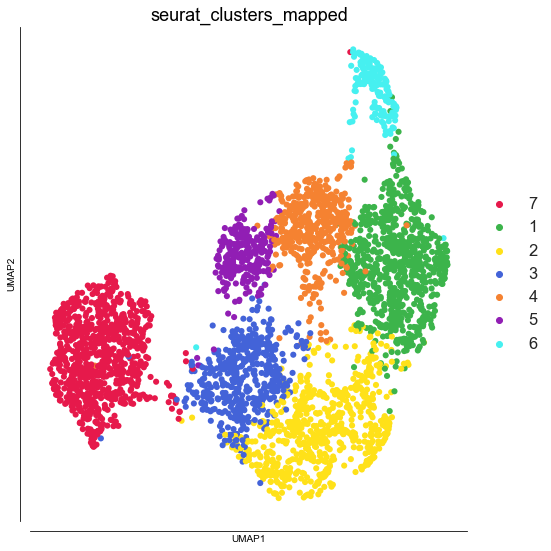

In [12]:
f, axs = plt.subplots(1,1,figsize=(8,8))
sns.set(font_scale=1.5)
sns.set_style("white")

fc.plotUMAP(adata, variable="seurat_clusters_mapped", components=["1,2"], palette=myColors, ax=axs)

sns.despine(offset=10, trim=False)
plt.tight_layout()
plt.show(block=False)
plt.close("all")

# Trajectory analysis

## New neighbourhood graph for PAGA

In [13]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_harmony")

## Paga and FDG - Harmony components

In [14]:
sc.tl.paga(adata, groups='seurat_clusters', model='v1.0')
sc.pl.paga(adata, plot=False)

sc.tl.draw_graph(adata,
                 init_pos  = 'paga',
                 root      = np.flatnonzero(adata.obs['seurat_clusters_mapped']  == '1')[0], 
                 adjacency = adata.uns['neighbors']['connectivities'],
                 maxiter   = 1000)

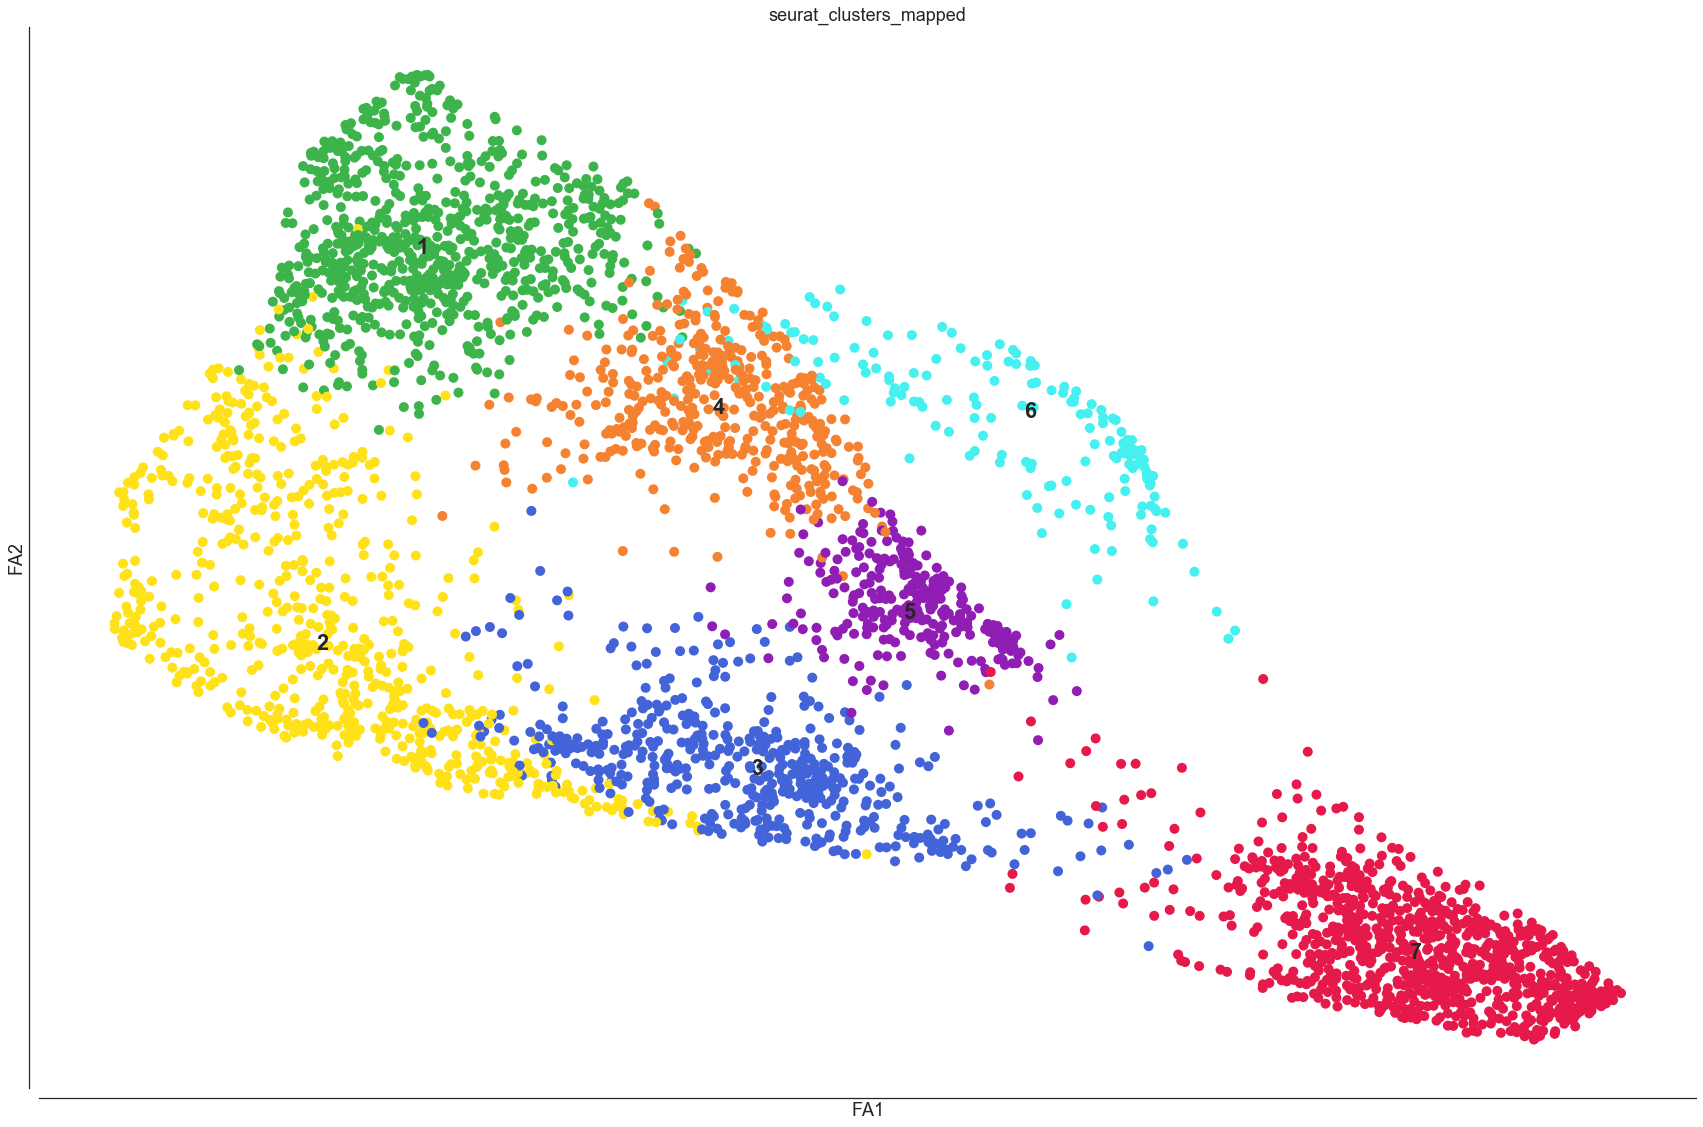

In [15]:
f, axs = plt.subplots(1,1,figsize=(24,16))
sns.set(font_scale=1.5)
sns.set_style("white")

sc.pl.draw_graph(adata, 
                 color           = 'seurat_clusters_mapped', 
                 palette         = myColors,
                 legend_loc      = 'on data', 
                 ax              = axs, 
                 show            = False, 
                 size            = 400, 
                 legend_fontsize = 'large')

sns.despine(offset=10, trim=False)
plt.tight_layout()
plt.show(block=False)
plt.close("all")

In [16]:
FA2_comp = pd.DataFrame(index   = adata.obs.index.tolist(),
                        columns = ["FA1", "FA2"],
                        data    = adata.obsm["X_draw_graph_fa"])

FA2_comp.to_csv("../MetaData/Resources/FA2_components_ATAC.csv")

## Pseudotime

In [17]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['seurat_clusters']  == '1')[0]

sc.tl.dpt(adata)

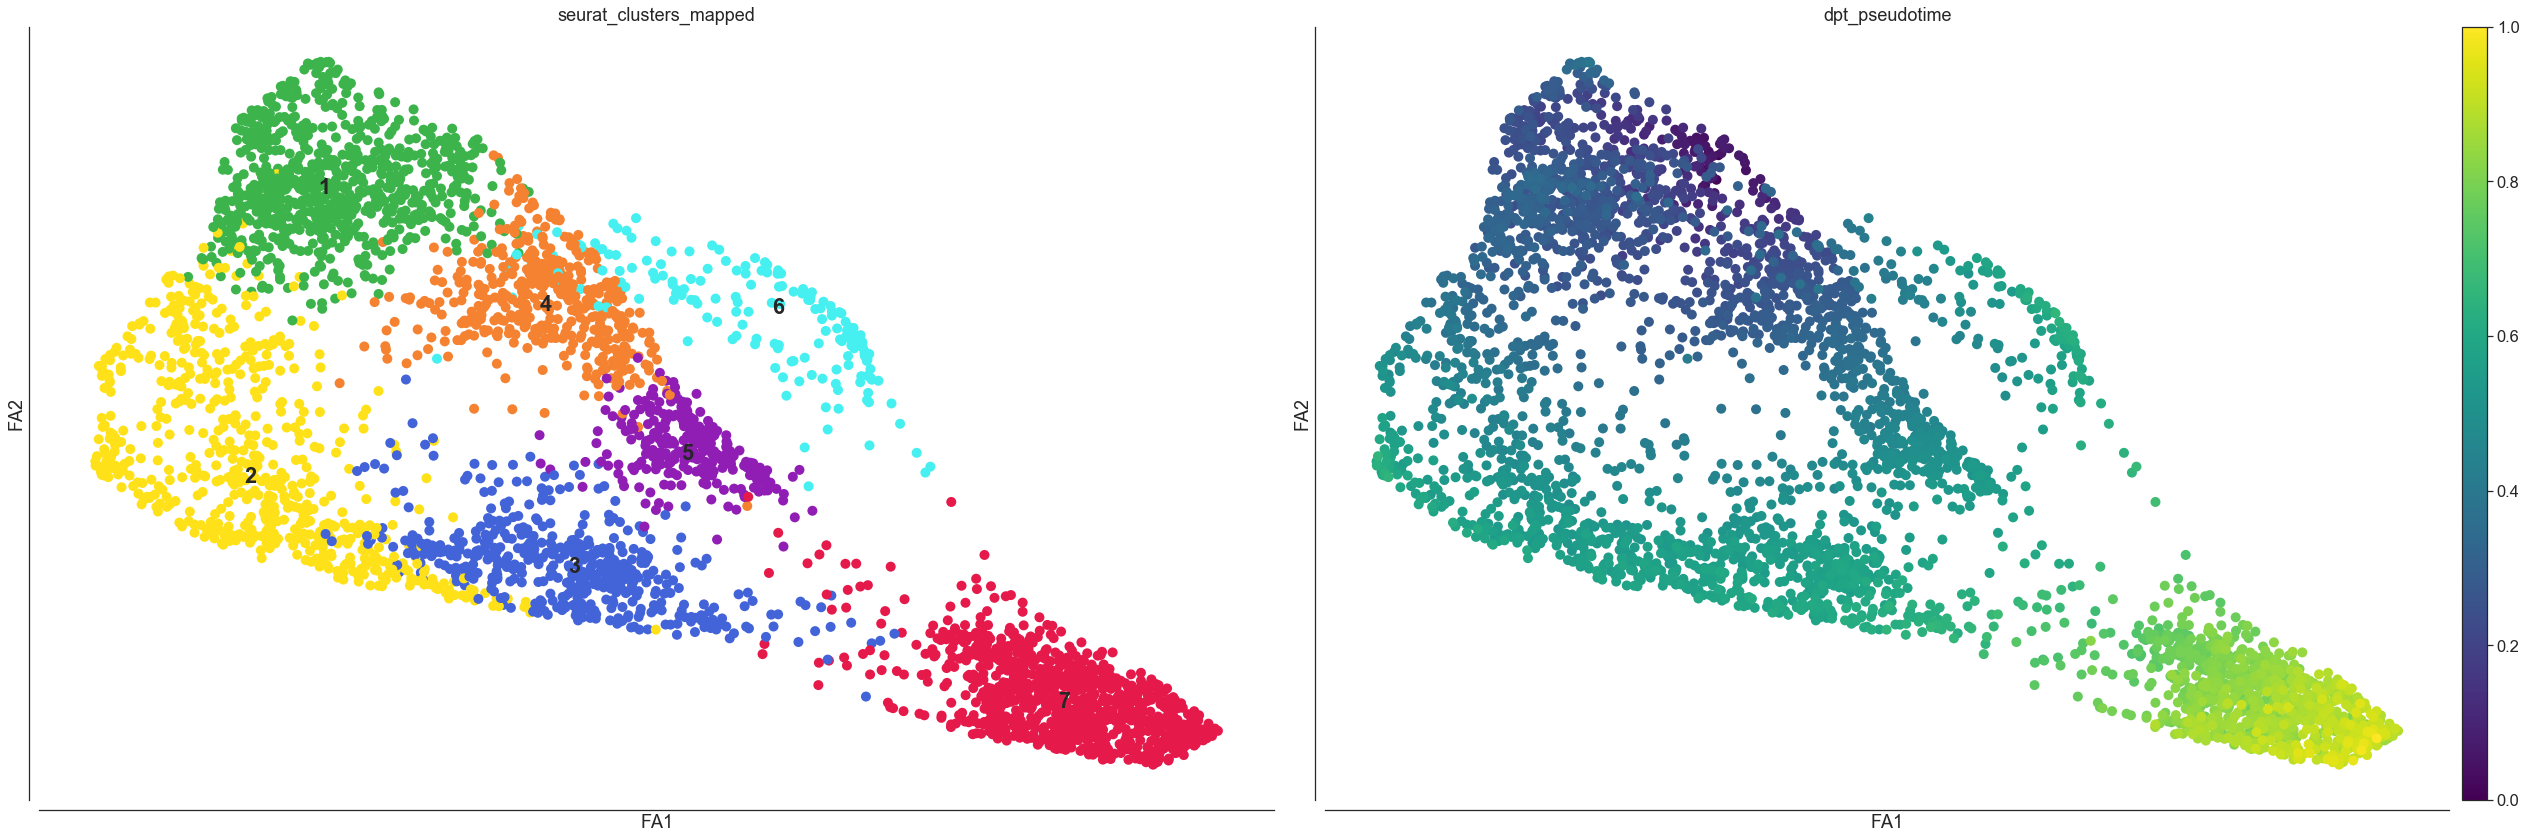

In [18]:
f, axs = plt.subplots(1,2,figsize=(36,12))
sns.set(font_scale=1.5)
sns.set_style("white")

sc.pl.draw_graph(adata, 
                 color           = 'seurat_clusters_mapped', 
                 palette         = myColors,
                 legend_loc      = 'on data', 
                 ax              = axs[0], 
                 show            = False, 
                 size            = 400, 
                 legend_fontsize = 'large')


sc.pl.draw_graph(adata, 
                 color           = 'dpt_pseudotime', 
                 legend_loc      = 'on data', 
                 ax              = axs[1], 
                 show            = False, 
                 size            = 400, 
                 color_map       = "viridis",
                 legend_fontsize = 'large')

sns.despine(offset=10, trim=False)
plt.tight_layout()
plt.show(block=False)
plt.close("all")

In [19]:
dpt_pseudotime = pd.DataFrame(index   = adata.obs.index.tolist(),
                              columns = ["Pseudotime"],
                              data    = adata.obs["dpt_pseudotime"].tolist())

dpt_pseudotime.to_csv("../MetaData/Resources/Pseudotime_ATAC.csv")